# General Data Science Playground
## The kaggle dataset for predicting boston house prices can be found on https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

## 0 Import the required packages and external functions

### 0.1 Packages

In [1]:
# First import the required packages
from IPython.display import HTML
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'
get_ipython().magic('matplotlib inline')

### 0.2 Hardcoded settings

In [2]:
MAX_LEVELS = 10
TOP_X = 10
TARGET_VARIABLE = "SalePrice"

## 1. Initial Prep of data
### 1.1 Read the files and check dimensions

In [3]:
def read_data():
    # Read the files
    test_data = pd.read_csv("test.csv")
    train_data_full = pd.read_csv("train.csv")
    
    # Seperate the target variable
    y_train = train_data_full[TARGET_VARIABLE]
    train_data = train_data_full.drop([TARGET_VARIABLE], 
                                 axis = 1, inplace = False)
    ###train_data = train_data.iloc[:,:-1]
    return train_data, test_data, y_train, train_data_full

train_data, test_data, y_train, train_data_full = read_data()

# Get a brief view of the data
print("There are", train_data.shape[0], "train samples")
print("There are", test_data.shape[0], "test samples")
print("\nThe target variable is:" ,TARGET_VARIABLE)
print("and the top 5 values are:")
print(y_train.nlargest(5).to_string(index=False))
###print(y_train.value_counts().index[:5].to_string(index=False))
print("In total there are", test_data.shape[1], "features")
print ("\nThose features are:\n", train_data.columns.tolist())
print ("\nThe data looks like this:\n", train_data.head())
print (train_data.describe())

There are 1460 train samples
There are 1459 test samples

The target variable is: SalePrice
and the top 5 values are:
755000
745000
625000
611657
582933
In total there are 80 features

Those features are:
 ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'Ga

### 1.2 Verify that everything is as expected

In [4]:
def assert_statements(train_data, test_data, y_train):
    assert train_data.shape[1] == test_data.shape[1], "Test and train data have different number of features!"
    assert train_data.Id.nunique()==train_data.shape[0], "IDs are not unique"
    assert y_train.isnull().sum()==0, "There are missing values in the target variable"

assert_statements(train_data, test_data, y_train)

### 1.2 Combine copies of test and train for prep, seperate the target variable

In [5]:
def prepare_preprocess(train_data, test_data):
    # Combine the training and test data for preprocessing purposes
    train_data['is_train'] = 1
    test_data['is_train'] = 0
    complete_data = pd.concat([train_data, test_data],
                              axis=0, ignore_index=True)
    return complete_data

complete_data = prepare_preprocess(train_data, test_data)

### 1.3 Basic understanding of the target variable

Skew is: 1.88287575977


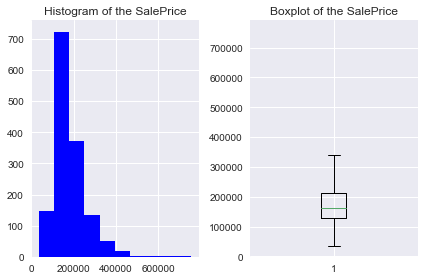

Skew is: 0.121346619897


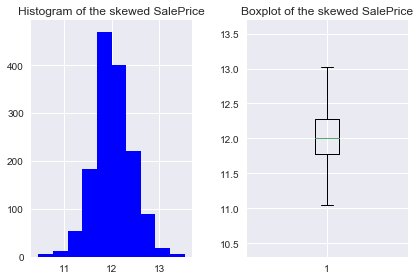

In [6]:
if y_train.dtypes == object:
    y_train = y_train.astype('category')
    # Get the frequency of the categorical levels
    print(y_train.value_counts(dropna = False))
    ###print(y_train.value_counts().index[:10].to_string(index=False)
    
    # Convert Target Variable from text to 0 and 1
    ##y_train = y_train.map({'positive': 1, 'negative': 0})
    ##print(y_train.head())
    
else:
    print ("Skew is:", y_train.skew())
    plt.subplot(1,2,1)
    plt.hist(y_train, color='blue')
    plt.title("Histogram of the %s" %(TARGET_VARIABLE))

    plt.subplot(1,2,2)
    plt.boxplot(y_train)
    plt.title("Boxplot of the %s" %(TARGET_VARIABLE))

    plt.tight_layout()
    plt.show()
    
    if y_train.skew()>1:
        y_train_unskewed = np.log1p(y_train)
        print ("Skew is:", y_train_unskewed.skew())
        plt.subplot(1,2,1)
        plt.hist(y_train_unskewed, color='blue')
        plt.title("Histogram of the skewed %s" %(TARGET_VARIABLE))

        plt.subplot(1,2,2)
        plt.boxplot(y_train_unskewed)
        plt.title("Boxplot of the skewed %s" %(TARGET_VARIABLE))

        plt.tight_layout()
        plt.show()

### 1.4 Converting to correct format (categories)

In [7]:
def to_categorical(dataset):
    # Check the type of features and convert objects to categorical
    categorical_features = dataset.select_dtypes(exclude=[np.number])
    categorical_columns = categorical_features.columns.tolist()
    
    for col in categorical_columns:
        dataset[col] = dataset[col].astype('category')

    return(categorical_features,categorical_columns)

def to_numerical(dataset):
    numeric_features = train_data.select_dtypes(include=[np.number])
    numeric_columns = numeric_features.columns.tolist()
    return(numeric_features, numeric_columns)

categorical_features,categorical_columns = to_categorical(complete_data)
numeric_features, numeric_columns = to_numerical(complete_data)

print("There are:",len(categorical_columns),"categorical features.\n ")
print(categorical_features.describe())
print("\n There are:",len(numeric_columns),"numeric features.\n ")
print(numeric_features.describe())

There are: 43 categorical features.
 
       MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      2915   2919   198     2919        2919      2917      2919   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       2265   2907   120     1859        2622      2916      2133   

       LandSlope Neighborhood Condition1      ...      GarageType  \
count       2919         2919       2919      ...            2762   
unique         3           25          9      ...               6   
top          Gtl        NAmes       Norm      ...          Attchd   
freq        2778          443       2511      ...            1723   

       GarageFinish GarageQual GarageCond PavedDrive PoolQC  Fence  \
count          2760       2760       2760       2919     10    571   
unique            3          5          5          3      3      4   
top             Unf         TA         T

## 2. EDA

### 2.1 Examine the correlation between numerical features and the target variable

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 

BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


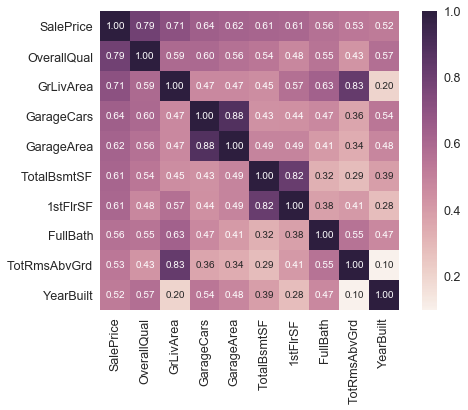

In [8]:
# Examine the correlation between numerical features
corrmat = train_data_full.corr()
print (corrmat[TARGET_VARIABLE].sort_values(ascending=False)[:TOP_X], '\n')
print (corrmat[TARGET_VARIABLE].sort_values(ascending=False)[-TOP_X:])

#TARGET_VARIABLE correlation matrix
cols = corrmat.nlargest(TOP_X, TARGET_VARIABLE)[TARGET_VARIABLE].index
cm = np.corrcoef(train_data_full[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': TOP_X}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### 2.2 Visualize interesting correlations

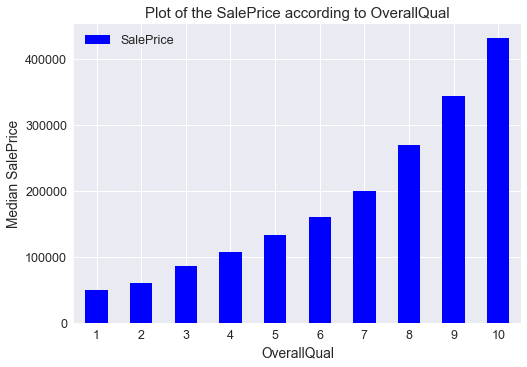

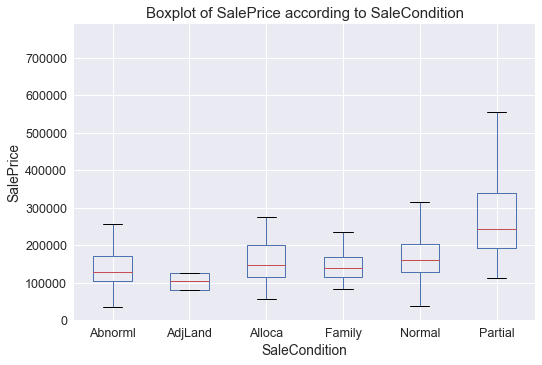

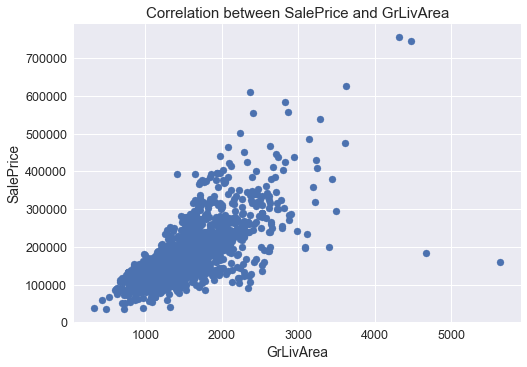

In [9]:
def plot_corr_numeric_cat_bar(dataset,feature):
    quality_pivot = dataset.pivot_table(index=feature, values=TARGET_VARIABLE, aggfunc=np.median)
    quality_pivot.plot(kind='bar', color='blue')
    plt.title("Plot of the %s according to %s" %(TARGET_VARIABLE,feature))
    plt.xlabel('%s' %(feature))
    plt.ylabel('Median %s' %(TARGET_VARIABLE))
    plt.xticks(rotation=0)
    plt.show()

def plot_corr_numeric_cat_box(dataset,feature):
    dataset.boxplot(column=TARGET_VARIABLE, by=feature)
    plt.title("Boxplot of %s according to %s" %(TARGET_VARIABLE,feature))
    plt.suptitle("")
    plt.ylabel('%s' %(TARGET_VARIABLE))
    plt.xlabel('%s' %(feature))
    plt.show()
    
def plot_corr_numeric_feat(dataset,feature):
    plt.scatter(data=dataset, x=feature, y=TARGET_VARIABLE)
    plt.title("Correlation between %s and %s" %(TARGET_VARIABLE,feature))
    plt.ylabel('%s' %(TARGET_VARIABLE))
    plt.xlabel('%s' %(feature))
    plt.show()
    
plot_corr_numeric_cat_bar(train_data_full,'OverallQual')
plot_corr_numeric_cat_box(train_data_full,'SaleCondition')
plot_corr_numeric_feat(train_data_full,'GrLivArea')

### 2.3 Basic Outlier remover

In [10]:
# Simple outlier removal, need more work
print("The highest five prices are:")
print(y_train.sort_values(ascending=False)[:5])
print(", whereas the 0.95 quantile:", y_train.quantile(0.95))

print("\nThe highest five GrLivArea are:")
print(complete_data[complete_data['is_train']==1]['GrLivArea'].sort_values(ascending=False)[:5])
print(", whereas the 0.95 quantile:", complete_data[complete_data['is_train']==1]['GrLivArea'].quantile(0.95))

indxs = (complete_data['GrLivArea'] > 4000) & (complete_data.is_train==1)
complete_data = complete_data[~indxs]
y_train = y_train[~indxs]
y_train_unskewed = y_train_unskewed[~indxs]

print("\nAfter removing, the highest five GrLivArea are:")
print(complete_data[complete_data['is_train']==1]['GrLivArea'].sort_values(ascending=False)[:5])
print(", whereas the 0.95 quantile:", complete_data[complete_data['is_train']==1]['GrLivArea'].quantile(0.95))

The highest five prices are:
691     755000
1182    745000
1169    625000
898     611657
803     582933
Name: SalePrice, dtype: int64
, whereas the 0.95 quantile: 326099.99999999994

The highest five GrLivArea are:
1298    5642
523     4676
1182    4476
691     4316
1169    3627
Name: GrLivArea, dtype: int64
, whereas the 0.95 quantile: 2466.1

After removing, the highest five GrLivArea are:
1169    3627
185     3608
304     3493
1268    3447
635     3395
Name: GrLivArea, dtype: int64
, whereas the 0.95 quantile: 2450.5


### 2.4 Examining Null Values

              Null Count  Null Percentage
Feature                                  
PoolQC              2907        99.725557
MiscFeature         2810        96.397942
Alley               2717        93.207547
Fence               2345        80.445969
FireplaceQu         1420        48.713551
LotFrontage          486        16.672384
GarageCond           159         5.454545
GarageYrBlt          159         5.454545
GarageFinish         159         5.454545
GarageQual           159         5.454545


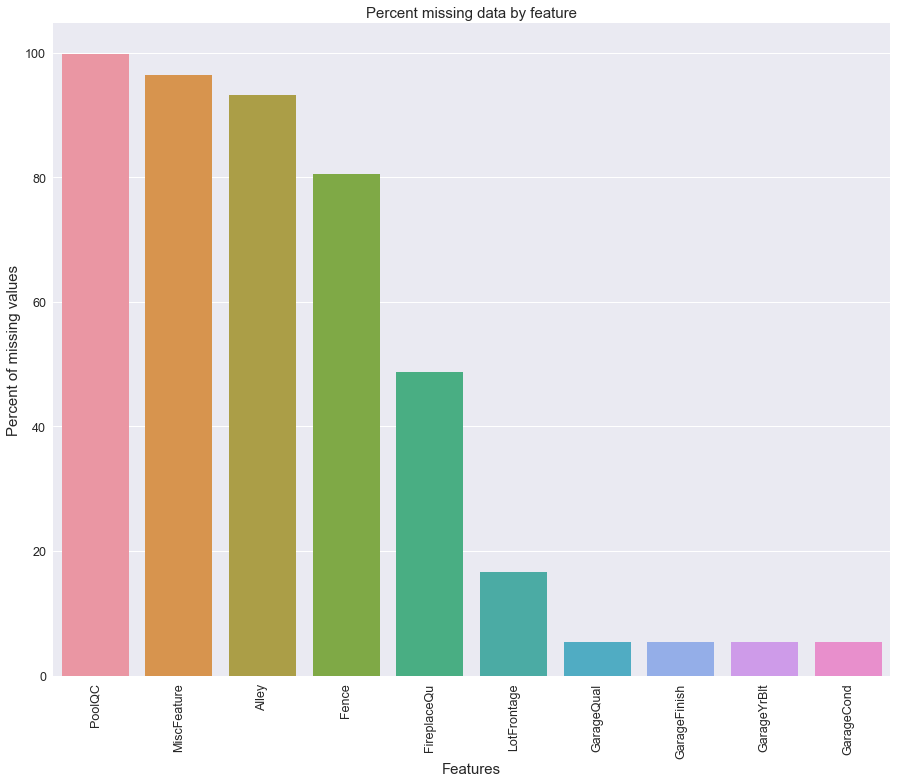

In [11]:
# Examine the TOP_X columns with most null values
def get_nulls(dataset):
    nulls = pd.DataFrame(dataset.isnull().sum().sort_values(ascending=False)[:TOP_X])
    nulls_perc = (dataset.isnull().sum() / len(dataset)) * 100
    nulls.columns = ['Null Count']
    nulls['Null Percentage'] = nulls_perc
    nulls.index.name = 'Feature'
    return nulls

def plot_null_values(nulls):
    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    sns.barplot(x = nulls['Null Percentage'].sort_values(ascending=False)[:TOP_X].index, 
                y = nulls['Null Percentage'].sort_values(ascending=False)[:TOP_X])
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)

nulls = get_nulls(complete_data)
print(nulls)
plot_null_values(nulls)

### 2.5 Dealing with Null Values

In [12]:
def average_imputing(dataset,impute_averages):
    for feature in impute_averages:
        if dataset[feature].dtype.name == "category":
            dataset[feature].fillna(value=dataset[feature].value_counts().index[0],
                   inplace=True)
        else:
            dataset[feature].fillna(value=dataset[feature].mean(),
                   inplace=True)

def zero_imputing(dataset,impute_zero):    
    for feature in impute_zero:
        if dataset[feature].dtype.name == "category":
            if "Missing" not in dataset[feature].cat.categories:
                dataset[feature].cat.add_categories(["Missing"], inplace=True)
            dataset[feature].fillna("Missing", inplace=True)
        else:
            dataset[feature].fillna(value = 0, inplace=True)
            dataset[feature].replace(".", 0, inplace=True)

# impute automatically (median or most-frequent)
impute_averages = ["MasVnrArea","Utilities","BsmtQual"]
impute_zero = complete_data.columns.tolist()

average_imputing(complete_data,impute_averages)
zero_imputing(complete_data,impute_zero)

## 3. Basic Feature Engineering
### 3.1 Modifying and creating features

In [13]:
# Group all minorly represented levels in one big level "Others"
# one can include the missing values in this "Others" level or not
def cutting(dataset, level_cut, max_level = MAX_LEVELS, incl_miss = 1):
    for feature in level_cut:
        if "Others" not in dataset[feature].cat.categories:
            dataset[feature].cat.add_categories(["Others"], inplace=True)
        if incl_miss == 1:
            pop_levels = dataset[feature].value_counts().index[:max_level-1]
            keep_indxs = dataset[feature].isin(pop_levels)
            dataset.loc[~keep_indxs, feature] = "Others"            
        else:
            pop_levels = dataset[feature].value_counts().loc[lambda x: x.index != 'Missing'].index[:max_level-1]
            keep_indxs = (dataset[feature].isin(pop_levels)) | (dataset[feature]=='Missing')
            dataset.loc[~keep_indxs, feature] = "Others"

# Create a feature with only two levels - the important one and the "others"
def max_cutting(dataset, feature, level):
    new_feature = 'EngFeat_2lvl_'+feature
    eng_data[new_feature] = 1 - ~(eng_data[feature] == level)
    print("A new column", new_feature, 
          "was created from", feature, 
          "indicating if the value is", level,
          "or not.")

# create a new column indicating that it is missing
def create_miss(dataset, indicators_feat):
    for feature in indicators_feat:
        new_feature='EngFeat_has_'+feature
        dataset[new_feature] = ~(dataset[feature]=="Missing")
        print("A new column", new_feature, 
              "was created from", feature, 
              "indicating if there is a", feature, 
              "or not.\n")
        
# Bin numerical variables (like age or just grouping ordered numericals)
def binning(dataset, features, levels):
    for feature in features:
        dataset[feature] = pd.qcut(dataset[feature], 
                                   q=levels, labels=False ,
                                   duplicates="drop")
        print(feature, "levels after grouping:")
        print(dataset[feature].value_counts(dropna=False))
        
# First create a new dataframe which will include the new features.
eng_data = complete_data.copy()    

# Manually modify a column
new_feature = "EngFeat_old"
basis_feature = "YearBuilt"
eng_data[new_feature]=eng_data[basis_feature].apply(lambda n : 2018-n)
print("A new column", new_feature,"was created from", 
      basis_feature, "indicating how old a house is.\n")

# Extract Title from Name, store in column and plot barplot
##eng_data['Title'] = eng_data.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))

cutting(eng_data, ["GarageCond"])

create_miss(eng_data, ["GarageCond"])

max_cutting(eng_data, "SaleCondition", 'Partial')

binning(eng_data,['LotArea'],4)


# One hot encoding features for all categorical, no need to fill miss values, no need to encode them
list_ohe = [col for col in eng_data if eng_data[col].dtypes.name == "category"]
print ("Number of categorical features considered to be one-hot encoded:", len(list_ohe))
list_ohe = ["Street","Alley"]
if len(list_ohe)<5:
    for feature in list_ohe:
        ohe_feature = pd.get_dummies(eng_data[feature],
                                     prefix='EngFeat_' + 
                                     feature, drop_first=True, 
                                     dummy_na=True)
        eng_data = pd.concat([eng_data, ohe_feature], 
                             axis=1);
    print("The following categorical features were successfully one-hot encoded: \n",list_ohe)
else:
    print("The categorical features are way too many for one hot encoding, consider other solutions")
    
# Label Encoder for the rest
list_le = [col for col in eng_data if eng_data[col].dtypes.name == "category"]
encoder = LabelEncoder()
for feature in list_le:
    eng_data[feature] = encoder.fit_transform(eng_data[feature])
print("The following categorical features were successfully encoded: \n",list_le)

# Standardize the other numerical variables
listToScale = [col for col in eng_data if 
               (eng_data[col].dtypes.name != "uint8") &
               (eng_data[col].dtypes.name != 'category') &
               (col!='Id') & (col!="is_train")]
statsCol=zip(eng_data[listToScale],
             eng_data[listToScale].mean(),
             eng_data[listToScale].std())
print("The mean and std of the numerical features for scaling considerations")
for stats in statsCol:
    print (stats)
listToScale = ['MSSubClass','LotFrontage']   
scaler = StandardScaler()                              
eng_data[listToScale]=scaler.fit_transform(eng_data[listToScale])

A new column EngFeat_old was created from YearBuilt indicating how old a house is.

A new column EngFeat_has_GarageCond was created from GarageCond indicating if there is a GarageCond or not.

A new column EngFeat_2lvl_SaleCondition was created from SaleCondition indicating if the value is Partial or not.
LotArea levels after grouping:
3    729
1    729
0    729
2    728
Name: LotArea, dtype: int64
Number of categorical features considered to be one-hot encoded: 43
The following categorical features were successfully one-hot encoded: 
 ['Street', 'Alley']
The following categorical features were successfully encoded: 
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', '

### 3.2 Deleting old ones

In [15]:
#Drop unnecesary stuff
listDrop = [colName for colName in eng_data.columns if (colName.find('Garage')>-1) & (colName.find('EngFeat')==-1)]
eng_data.drop(listDrop, axis=1, inplace = True)
eng_data.drop(list_ohe, axis=1, inplace = True)

## 4. Creating a Model
### 4.1 Define the training, test sets

In [166]:
# First get back to the training and test data
X_train = eng_data[eng_data.is_train==1]
X_test = eng_data[eng_data.is_train==0]
X_train.drop(["is_train","Id"], axis=1, inplace = True)
X_test.drop(["is_train","Id"], axis=1, inplace = True)

# Create a train/test set
TEST_SIZE=.3
data_train, data_test, pred_train, pred_test = train_test_split(X_train, y_train_unskewed, random_state=1, test_size=TEST_SIZE)
print("The train / test size ration is:",1-TEST_SIZE,"/",TEST_SIZE)

The train / test size ration is: 0.7 / 0.3


### 4.2 Define the necessary functions

In [152]:
def model_builder(model, params, cv = 5):
    grid_model = GridSearchCV(estimator=model, 
                              param_grid=params, 
                              scoring='neg_mean_squared_error', 
                              cv=cv, 
                              verbose=0)
    grid_model.fit(data_train, pred_train)
    return grid_model

def print_results(grid_model, params, name, cv = 5):
    plt.figure(figsize=[13,8])
    sizeParam = len(params.keys())
    param1 = list(params.keys())[0]
    
    if sizeParam==1:
        plt.plot(params.get(param1), 
                 np.sqrt(np.abs(grid_model.cv_results_['mean_test_score'])))
    
    if sizeParam>1:
        param2 = list(params.keys())[1]
        sizeParam2 = len(params.get(param2))
        for i in range(sizeParam2):
            plt.plot(params.get(param1), 
                     np.sqrt(np.abs(grid_model.cv_results_['mean_test_score'][i::sizeParam2])),
                     label = str('CV Score for '+ 
                                 param2 +' = ' 
                                 + str(params.get(param2)[i])))
            plt.legend()
    plt.title(name + " Grid Search " + str(cv) + "-fold CV")
    plt.xlabel('{}'.format(list(params.keys())[0]))
    plt.ylabel('RMSE')
    plt.xticks(params.get(param1),params.get(param1))
    plt.show()
    print("Best parameters found: ", grid_model.best_params_)
    print("RMSE on train: ", np.round(np.sqrt(np.abs(
        grid_model.best_score_)),3))
    print("RMSE on test:", np.round(np.sqrt(np.abs(
        grid_model.score(data_test, pred_test))),3))

def print_feature_ranking(grid_model, name, top_x = 10, with_std = 0 , coef = 0):
    # Print the feature ranking
    if coef == 1:
        importances = grid_model.best_estimator_.coef_
        print(name, "picked" , str(sum(importances != 0)) , 
              "variables and eliminated the other ",
              str(sum(importances == 0)), 
              "variables")

    else:    
        importances = grid_model.best_estimator_.feature_importances_
        
    indices = np.argsort(importances)[-top_x:]
    print("\nFeature ranking for", name)
    for f in np.arange(top_x-1,-1,-1):
        print("%d. %s (%f)" % (top_x-f, data_train.iloc[:,indices[f]].name, 
                               importances[indices[f]]))
    # Plot the feature importances of the model
    plt.figure()
    plt.title("Feature importances for " + name)
    if with_std == 1:
        std = np.std([tree.feature_importances_ for tree in 
              grid_model.best_estimator_.estimators_],
             axis = 0)
        plt.bar(range(top_x), 
                importances[indices], 
                color="r",
                yerr=std[indices],
                align="center")
    else:
        plt.bar(range(top_x), 
                importances[indices], 
                color="r",
                align="center")
    plt.xticks(range(top_x), 
               data_train.iloc[:,indices].columns.tolist(),
               rotation=75)
    plt.xlim([-1, top_x])
    plt.show()
    
def print_predicted(grid_model, name):
    model_pred = grid_model.predict(data_test)

    plt.scatter(np.expm1(model_pred), 
                np.expm1(pred_test), 
                alpha=.75, color='b') #alpha helps to show overlapping data
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title(name + " with = {}".format(grid_model.best_params_))
    overlay = 'RMSE is: {}'.format(
                        np.round(np.sqrt(mean_squared_error(pred_test, model_pred)),3))
    plt.annotate(s=overlay,xy=(0.65, 0.15),xycoords='figure fraction',size='large')
    plt.show()

### 4.2 Fitting a Lasso Linear Regression

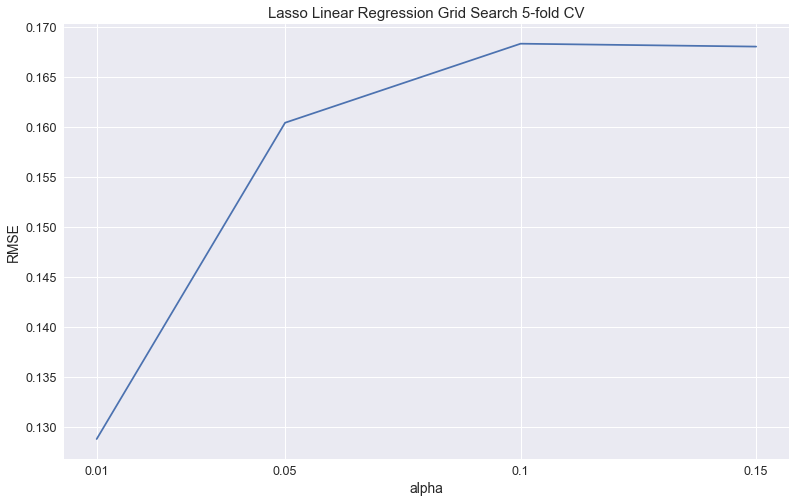

Best parameters found:  {'alpha': 0.01}
RMSE on train:  0.129
RMSE on test: 0.138
Lasso Linear Regression picked 35 variables and eliminated the other  44 variables

Feature ranking for Lasso Linear Regression
1. OverallQual (0.065103)
2. OverallCond (0.035253)
3. SaleCondition (0.023319)
4. LotArea (0.015615)
5. Functional (0.011182)
6. Fireplaces (0.006194)
7. YearBuilt (0.003275)
8. Exterior2nd (0.001026)
9. Neighborhood (0.000923)
10. YearRemodAdd (0.000880)


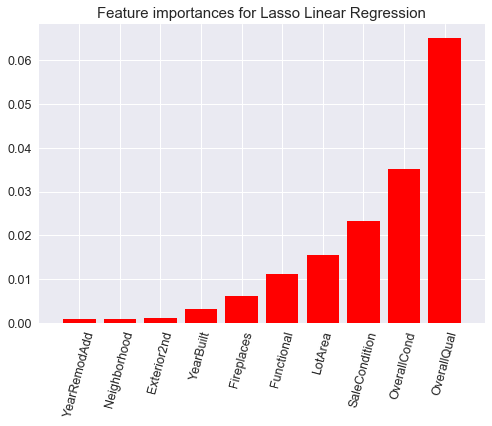

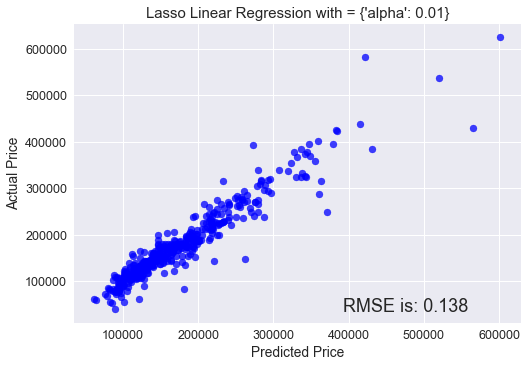

In [153]:
# Fitting a Lasso Linear Regression
lasso_param_grid = {'alpha': [0.01,0.05,0.1,0.15]}
lasso = linear_model.Lasso()
lasso_model = model_builder(lasso, lasso_param_grid)

print_results(lasso_model, lasso_param_grid, "Lasso Linear Regression")
print_feature_ranking(lasso_model, "Lasso Linear Regression", coef = 1)
print_predicted(lasso_model, "Lasso Linear Regression")

### 4.3 Fitting a K-Neighbors Regressor

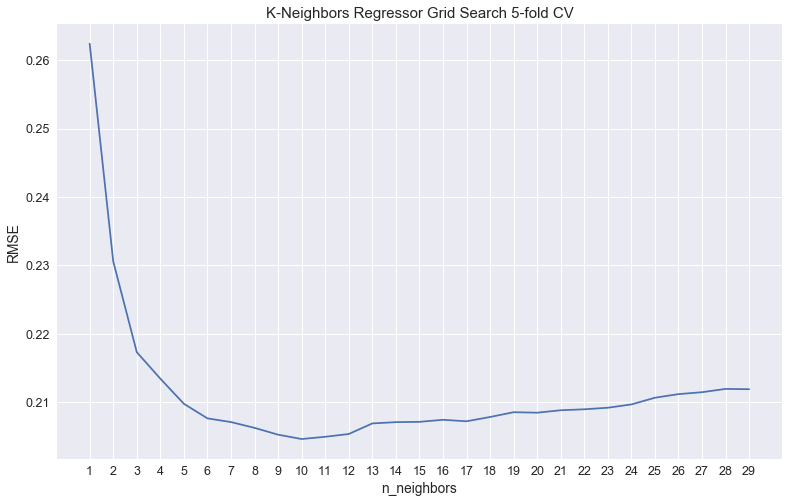

Best parameters found:  {'n_neighbors': 10}
RMSE on train:  0.205
RMSE on test: 0.225


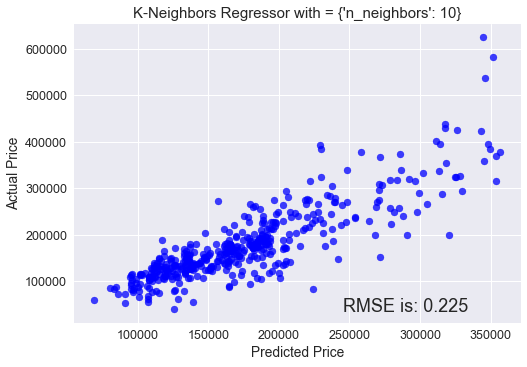

In [154]:
# Fitting a K-Neighbors Regressor
knn_param_grid = {'n_neighbors': list(np.arange(1, 30))}
knn = KNeighborsRegressor()
knn_model = model_builder(knn, knn_param_grid)

print_results(knn_model, knn_param_grid, "K-Neighbors Regressor")
print_predicted(knn_model, "K-Neighbors Regressor")

### 4.5 Fitting a Random Forest

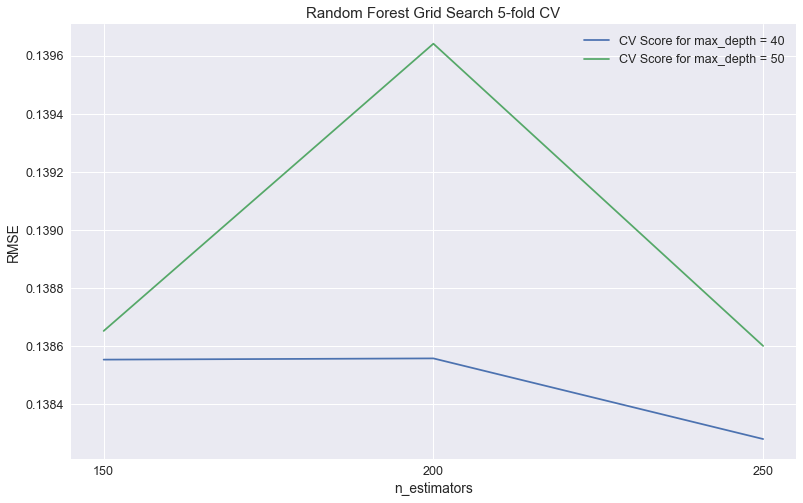

Best parameters found:  {'max_depth': 50, 'n_estimators': 200}
RMSE on train:  0.138
RMSE on test: 0.145

Feature ranking for Random Forest
1. OverallQual (0.548582)
2. GrLivArea (0.140108)
3. TotalBsmtSF (0.057246)
4. 1stFlrSF (0.031608)
5. BsmtFinSF1 (0.023746)
6. EngFeat_old (0.016646)
7. YearBuilt (0.014095)
8. YearRemodAdd (0.012219)
9. OverallCond (0.010069)
10. MSZoning (0.009836)


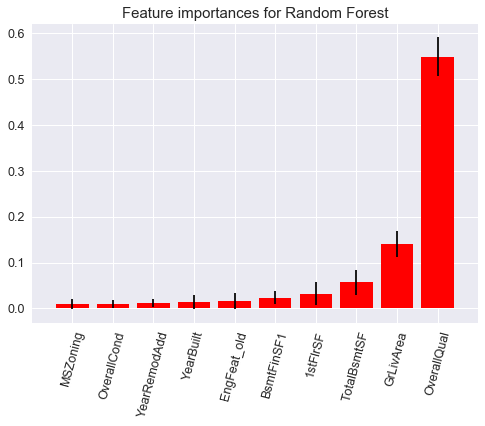

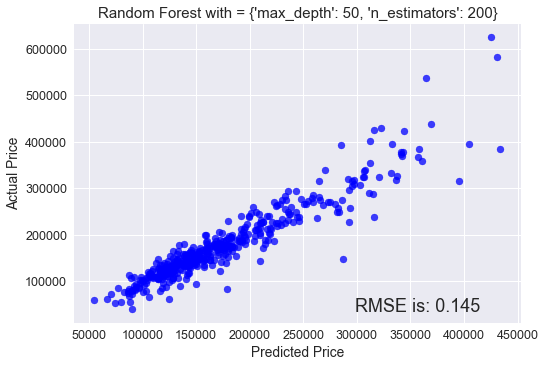

In [156]:
# Fitting a Random Forest
rf_param_grid = {'n_estimators': [150, 200, 250], 
                  'max_depth': [40, 50]}
rf = RandomForestRegressor()
rf_model = model_builder(rf, rf_param_grid)

print_results(rf_model, rf_param_grid, "Random Forest")
print_feature_ranking(rf_model, "Random Forest", with_std = 1)
print_predicted(rf_model, "Random Forest")

### 4.6 Fitting a Gradient Boosting Regressor

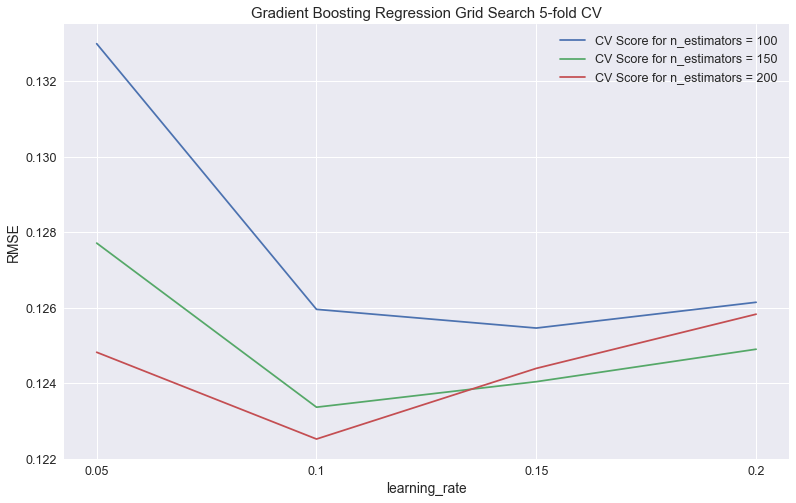

Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 200}
RMSE on train:  0.123
RMSE on test: 0.131

Feature ranking for Gradient Boosting Regression
1. GrLivArea (0.088855)
2. OverallQual (0.056500)
3. MoSold (0.039279)
4. OverallCond (0.038693)
5. YearBuilt (0.038098)
6. EngFeat_old (0.037385)
7. Neighborhood (0.035460)
8. TotalBsmtSF (0.034864)
9. LotFrontage (0.032284)
10. YearRemodAdd (0.032274)


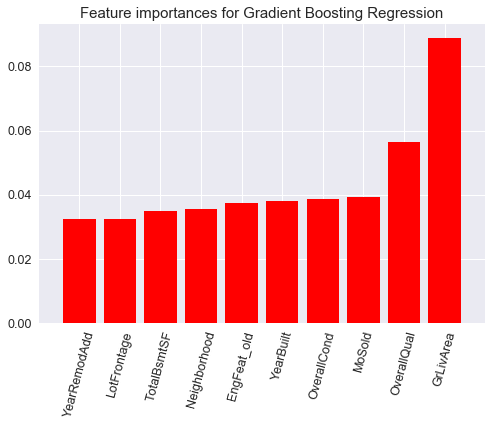

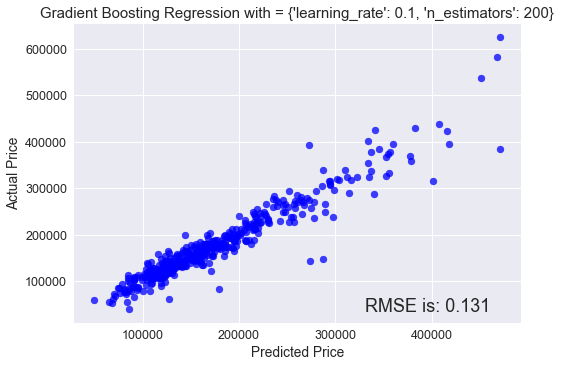

In [157]:
# Fitting a Gradient Boosting Regressor
gbm_param_grid = {'learning_rate': [0.05,0.1,0.15,0.2], 
                  'n_estimators': [100,150,200]}
gbm = GradientBoostingRegressor()
gbm_model = model_builder(gbm, gbm_param_grid)

print_results(gbm_model, gbm_param_grid, "Gradient Boosting Regression")
print_feature_ranking(gbm_model, "Gradient Boosting Regression")
print_predicted(gbm_model, "Gradient Boosting Regression")

## 5. Make the final predictions

In [167]:
predictions_lasso = lasso_model.predict(X_test)
predictions_knn = knn_model.predict(X_test)
predictions_rf = rf_model.predict(X_test)
predictions_gbm = gbm_model.predict(X_test)

submission = pd.DataFrame()
submission['Id'] = test_data.Id
final_predictions = 0.4*np.expm1(predictions_gbm) + 0.2*(
    np.expm1(predictions_lasso) 
    + 0.2*np.expm1(predictions_knn) 
    + 0.2*np.expm1(predictions_rf))
submission['SalePrice'] = final_predictions
print(submission.head())
submission.to_csv('submission1.csv', index=False)


     Id      SalePrice
0  1461   84773.487779
1  1462  110076.383508
2  1463  126905.214261
3  1464  132160.556779
4  1465  128149.672658
